
# Irish Weather ML Mini‑Lab (ERA5: Dublin, Galway, Cork — 2024)

This notebook works **entirely offline** from a single CSV file:  
`era5_ireland3_t2m_wind_2024.csv`

We’ll build three tiny PyTorch models using that dataset:

1. **Nowcasting by naive autoregression:** Predict *Dublin 2m temperature* at time *t* from *t−1* (using a small sample).  
2. **1D CNN (temporal):** Predict *Dublin 2m temperature* using recent **multivariate** history from the **other variables** (Galway & Cork temps; 10m wind speeds at Dublin, Galway, Cork).  
3. **2D CNN (spatio‑temporal):** Predict **(Dublin, Galway, Cork) 2m temperatures** jointly from a short spatio‑temporal window.

> Designed to be simple, quick to run on CPU, and easy to modify for teaching.


## 0) Setup

In [1]:

# If you need to install packages inside your environment, uncomment as needed.
# %pip install pandas numpy scikit-learn torch matplotlib

import os, math, random, pathlib, warnings
from dataclasses import dataclass
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

CSV_PATH = "../../data/era5_ireland3_t2m_wind_2024.csv"  # Put this file in the same folder as this notebook
assert pathlib.Path(CSV_PATH).exists(), f"Couldn't find {CSV_PATH}. Place it next to this notebook."
print('Found:', CSV_PATH)


Found: ../../data/era5_ireland3_t2m_wind_2024.csv


## 1) Load & explore data

In [2]:

df = pd.read_csv(CSV_PATH, parse_dates=['time'])
df = df.sort_values('time').reset_index(drop=True)
df.head(10)


,time,Dublin_t2m_degC,Galway_t2m_degC,Cork_t2m_degC,Dublin_wind_speed10m_ms,Galway_wind_speed10m_ms,Cork_wind_speed10m_ms
0,2024-01-01 00:00:00,5.763580,6.396393,5.617096,8.426119,6.120335,4.927529
1,2024-01-01 01:00:00,5.445953,5.922516,5.094391,8.082199,5.639297,4.454760
2,2024-01-01 02:00:00,5.434723,5.518707,4.604645,7.943061,4.928046,3.922362
3,2024-01-01 03:00:00,5.265533,5.257721,4.111237,7.585234,4.344268,3.177118
4,2024-01-01 04:00:00,5.138092,5.163483,3.917389,7.084112,3.941263,2.874048
5,2024-01-01 05:00:00,4.756500,4.942047,3.736969,6.406179,3.654643,2.792242
6,2024-01-01 06:00:00,4.561676,5.036285,4.006989,5.725153,3.007741,2.427059
7,2024-01-01 07:00:00,4.480377,4.542877,3.931549,4.984876,2.270232,2.208974
8,2024-01-01 08:00:00,4.141510,4.815338,4.082916,3.957492,2.576190,2.211656
9,2024-01-01 09:00:00,3.872467,4.452545,5.204498,3.408133,3.079721,2.863055


Date coverage: 2024-01-01 00:00:00 → 2024-12-31 23:00:00 (8784 rows)


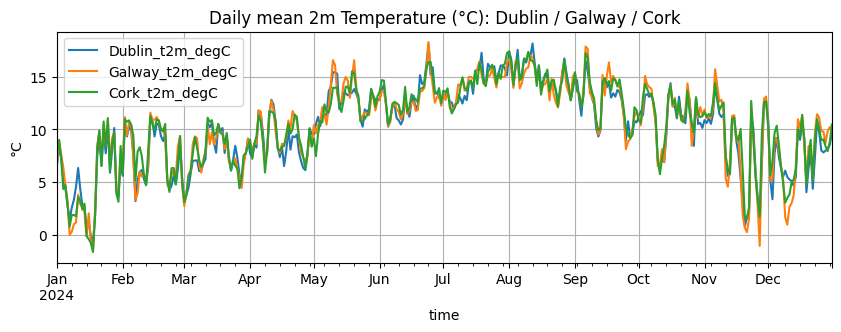

In [3]:

print('Date coverage:', df['time'].min(), '→', df['time'].max(), f"({len(df)} rows)")
ax = df.set_index('time')[['Dublin_t2m_degC','Galway_t2m_degC','Cork_t2m_degC']].resample('1D').mean().plot(figsize=(10,3))
ax.set_title('Daily mean 2m Temperature (°C): Dublin / Galway / Cork')
ax.set_ylabel('°C'); ax.grid(True); plt.show()


## 2) Train/Validation/Test split (by time)

In [4]:

# Split: first 70% train, next 15% val, final 15% test (time-ordered)
n = len(df)
i_tr = int(0.70*n)
i_va = int(0.85*n)
splits = {'train': (0, i_tr), 'val': (i_tr, i_va), 'test': (i_va, n)}
splits


{'train': (0, 6148), 'val': (6148, 7466), 'test': (7466, 8784)}


## 3) Task A — Predict Dublin temperature from the **previous hour**

A minimal baseline:  
\(
\hat{y}_t = a \cdot y_{t-1} + b
\)

We’ll fit a tiny linear layer `nn.Linear(1,1)` on a **small sample** (first 2000 rows) to keep it very fast.


Epoch 100 | train MSE=0.4293 | val MSE=0.2801
Epoch 200 | train MSE=0.3027 | val MSE=0.2285
Epoch 300 | train MSE=0.2439 | val MSE=0.2026
Test MSE: 0.2715878486633301


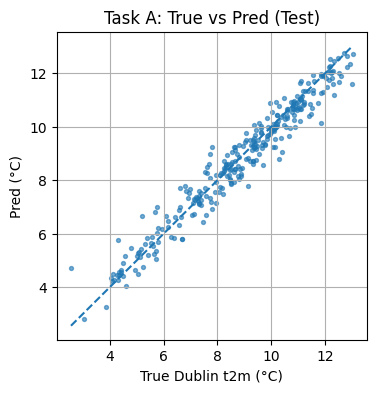

Fitted a,b: [[0.9493275880813599], [0.37573325634002686]]


In [5]:

# Build lag-1 features for Dublin t2m
dd = df[['time','Dublin_t2m_degC']].copy()
dd['y'] = dd['Dublin_t2m_degC']
dd['x_lag1'] = dd['y'].shift(1)
dd = dd.dropna().reset_index(drop=True)

small = dd.iloc[:2000].copy() if len(dd) > 2000 else dd.copy()  # small sample
i_tr, i_va, i_te = int(0.7*len(small)), int(0.85*len(small)), len(small)
X = torch.tensor(small['x_lag1'].values, dtype=torch.float32).unsqueeze(1)
y = torch.tensor(small['y'].values, dtype=torch.float32).unsqueeze(1)

X_tr, y_tr = X[:i_tr], y[:i_tr]
X_va, y_va = X[i_tr:i_va], y[i_tr:i_va]
X_te, y_te = X[i_va:i_te], y[i_va:i_te]

model_A = nn.Linear(1,1)
opt = torch.optim.Adam(model_A.parameters(), lr=0.05)
loss_fn = nn.MSELoss()

for epoch in range(300):
    model_A.train()
    opt.zero_grad()
    yhat = model_A(X_tr)
    loss = loss_fn(yhat, y_tr)
    loss.backward(); opt.step()

    if (epoch+1) % 100 == 0:
        with torch.no_grad():
            val = loss_fn(model_A(X_va), y_va).item()
        print(f"Epoch {epoch+1:3d} | train MSE={loss.item():.4f} | val MSE={val:.4f}")

with torch.no_grad():
    test_mse = loss_fn(model_A(X_te), y_te).item()
    print("Test MSE:", test_mse)

# Quick scatter
with torch.no_grad():
    yh = model_A(X_te).squeeze().numpy()
plt.figure(figsize=(4,4))
plt.scatter(y_te.squeeze().numpy(), yh, s=8, alpha=0.6)
plt.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], linestyle='--')
plt.title('Task A: True vs Pred (Test)')
plt.xlabel('True Dublin t2m (°C)'); plt.ylabel('Pred (°C)'); plt.grid(True); plt.show()

print('Fitted a,b:', [p.detach().numpy().ravel().tolist() for p in model_A.parameters()])



## 4) Task B — **1D CNN** to predict Dublin t2m from **other variables**

**Inputs (per time step):**  
- Galway_t2m_degC, Cork_t2m_degC  
- Dublin_wind_speed10m_ms, Galway_wind_speed10m_ms, Cork_wind_speed10m_ms

We build sequences of length `T=24` hours and predict Dublin t2m at the **next hour**.


In [6]:

from sklearn.preprocessing import StandardScaler

INPUT_COLS_B = [
    'Galway_t2m_degC','Cork_t2m_degC',
    'Dublin_wind_speed10m_ms','Galway_wind_speed10m_ms','Cork_wind_speed10m_ms'
]
TARGET_COL_B = 'Dublin_t2m_degC'
T = 24  # sequence length

# Time-ordered split
i0, i1 = splits['train']
j0, j1 = splits['val']
k0, k1 = splits['test']

train_df = df.iloc[i0:i1].copy()
val_df   = df.iloc[j0:j1].copy()
test_df  = df.iloc[k0:k1].copy()

# Scale features (fit on train only)
sc_X = StandardScaler().fit(train_df[INPUT_COLS_B].values)
sc_y = StandardScaler().fit(train_df[[TARGET_COL_B]].values)  # scale target helps training

def build_sequences(frame):
    X_raw = sc_X.transform(frame[INPUT_COLS_B].values)
    y_raw = sc_y.transform(frame[[TARGET_COL_B]].values).ravel()
    X_seq, y_seq = [], []
    for t in range(len(frame) - T - 1):
        X_seq.append(X_raw[t:t+T].T)   # shape: (C, T)
        y_seq.append(y_raw[t+T])       # predict next hour
    X_seq = np.stack(X_seq)            # (N, C, T)
    y_seq = np.array(y_seq)           # (N,)
    return X_seq, y_seq

Xtr, ytr = build_sequences(train_df)
Xva, yva = build_sequences(val_df)
Xte, yte = build_sequences(test_df)

Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
Xva_t = torch.tensor(Xva, dtype=torch.float32)
Xte_t = torch.tensor(Xte, dtype=torch.float32)
ytr_t = torch.tensor(ytr, dtype=torch.float32).unsqueeze(1)
yva_t = torch.tensor(yva, dtype=torch.float32).unsqueeze(1)
yte_t = torch.tensor(yte, dtype=torch.float32).unsqueeze(1)

class CNN1D_Dublin(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),   # → (batch, 32, 1)
            nn.Flatten(),              # → (batch, 32)
            nn.Linear(32, 1)
        )
    def forward(self, x):  # x: (B, C, T)
        return self.net(x)

model_B = CNN1D_Dublin(in_channels=Xtr_t.shape[1])
optB = torch.optim.Adam(model_B.parameters(), lr=3e-3)
loss_fn = nn.MSELoss()

def train_simple(model, Xtr, ytr, Xva, yva, epochs=8, batch=128):
    tr_loader = DataLoader(list(zip(Xtr, ytr)), batch_size=batch, shuffle=True)
    for ep in range(epochs):
        model.train()
        ls = 0.0
        for xb, yb in tr_loader:
            optB.zero_grad()
            yh = model(xb)
            loss = loss_fn(yh, yb)
            loss.backward(); optB.step()
            ls += loss.item()*len(xb)
        with torch.no_grad():
            val = loss_fn(model(Xva), yva).item()
        print(f"Epoch {ep+1:02d} | train MSE={ls/len(Xtr):.4f} | val MSE={val:.4f}")

train_simple(model_B, Xtr_t, ytr_t, Xva_t, yva_t, epochs=10)

with torch.no_grad():
    mse_te = loss_fn(model_B(Xte_t), yte_t).item()
    print('Test MSE (scaled):', mse_te)
    # Convert to °C RMSE
    import numpy as _np
    rmse_degC = float(_np.sqrt(mse_te) * sc_y.scale_[0])
    print('Test RMSE (°C):', rmse_degC)


Epoch 01 | train MSE=0.4181 | val MSE=0.2155
Epoch 02 | train MSE=0.2439 | val MSE=0.2094
Epoch 03 | train MSE=0.2375 | val MSE=0.1908
Epoch 04 | train MSE=0.2318 | val MSE=0.1961
Epoch 05 | train MSE=0.2275 | val MSE=0.1979
Epoch 06 | train MSE=0.2232 | val MSE=0.2085
Epoch 07 | train MSE=0.2108 | val MSE=0.1810
Epoch 08 | train MSE=0.2005 | val MSE=0.1948
Epoch 09 | train MSE=0.1821 | val MSE=0.1757
Epoch 10 | train MSE=0.1644 | val MSE=0.1588
Test MSE (scaled): 0.18023104965686798
Test RMSE (°C): 1.8993635975466523


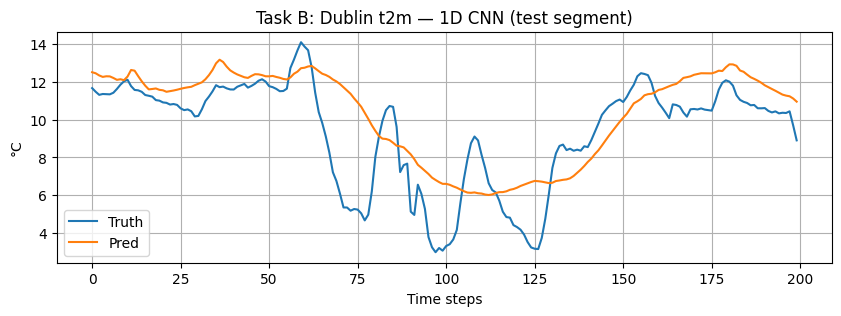

In [7]:

# Quick qualitative check: a short segment
with torch.no_grad():
    pred_scaled = model_B(Xte_t).squeeze().numpy()
pred = sc_y.inverse_transform(pred_scaled.reshape(-1,1)).ravel()
truth = sc_y.inverse_transform(yte_t.numpy()).ravel()

nplot = 200
plt.figure(figsize=(10,3))
plt.plot(truth[:nplot], label='Truth')
plt.plot(pred[:nplot], label='Pred')
plt.title('Task B: Dublin t2m — 1D CNN (test segment)')
plt.ylabel('°C'); plt.xlabel('Time steps'); plt.legend(); plt.grid(True); plt.show()



## 5) Task C — **2D CNN** for joint (Dublin, Galway, Cork) temperatures

We encode a **spatio‑temporal patch**:
- **Time axis:** last `T=24` hours
- **Space axis:** the three cities ordered as `[Dublin, Galway, Cork]`
- **Channels:** for each city we include **(t2m, wind10m)** → total 6 channels

Tensor shape per sample: **(C=6, T=24, S=3)**, which we pass to a small `Conv2d` by
treating **T × S** as a 2D grid.

**Target:** 3‑vector of the **next‑hour** temperatures (Dublin, Galway, Cork), in °C.


In [8]:

from sklearn.preprocessing import StandardScaler

CITIES = ['Dublin','Galway','Cork']
T = 24
# channel order: [Dub_t2m, Dub_ws, Gal_t2m, Gal_ws, Cork_t2m, Cork_ws]
INPUT_COLS_C = [
    'Dublin_t2m_degC','Dublin_wind_speed10m_ms',
    'Galway_t2m_degC','Galway_wind_speed10m_ms',
    'Cork_t2m_degC','Cork_wind_speed10m_ms'
]
TARGET_COLS_C = ['Dublin_t2m_degC','Galway_t2m_degC','Cork_t2m_degC']

# Reuse train/val/test from earlier
train_df = df.iloc[splits['train'][0]:splits['train'][1]]
val_df   = df.iloc[splits['val'][0]:splits['val'][1]]
test_df  = df.iloc[splits['test'][0]:splits['test'][1]]

sc_XC = StandardScaler().fit(train_df[INPUT_COLS_C].values)
sc_yC = StandardScaler().fit(train_df[TARGET_COLS_C].values)

def build_spatiotemporal(frame):
    Xr = sc_XC.transform(frame[INPUT_COLS_C].values)  # shape (N, 6)
    Yr = sc_yC.transform(frame[TARGET_COLS_C].values) # shape (N, 3)
    X_seq, Y_seq = [], []
    for t in range(len(frame) - T - 1):
        patch = Xr[t:t+T]                 # (T, 6)
        dub = np.stack([patch[:,0], patch[:,1]], axis=1)  # (T, 2)
        gal = np.stack([patch[:,2], patch[:,3]], axis=1)  # (T, 2)
        cor = np.stack([patch[:,4], patch[:,5]], axis=1)  # (T, 2)

        Xts = np.zeros((6, T, 3), dtype=np.float32)
        Xts[0,:,0] = dub[:,0];  Xts[1,:,0] = dub[:,1]
        Xts[2,:,1] = gal[:,0];  Xts[3,:,1] = gal[:,1]
        Xts[4,:,2] = cor[:,0];  Xts[5,:,2] = cor[:,1]

        X_seq.append(Xts)                     # (6, T, 3)
        Y_seq.append(Yr[t+T])                 # (3,)
    return np.stack(X_seq), np.stack(Y_seq)

XtrC, ytrC = build_spatiotemporal(train_df)
XvaC, yvaC = build_spatiotemporal(val_df)
XteC, yteC = build_spatiotemporal(test_df)

XtrC_t = torch.tensor(XtrC, dtype=torch.float32)
XvaC_t = torch.tensor(XvaC, dtype=torch.float32)
XteC_t = torch.tensor(XteC, dtype=torch.float32)
ytrC_t = torch.tensor(ytrC, dtype=torch.float32)
yvaC_t = torch.tensor(yvaC, dtype=torch.float32)
yteC_t = torch.tensor(yteC, dtype=torch.float32)

class CNN2D_TripleCity(nn.Module):
    def __init__(self, in_channels=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),   # → (B, 32, 1, 1)
            nn.Flatten(),                  # → (B, 32)
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3)               # predict 3 temps
        )
    def forward(self, x):  # x: (B, C=6, T, S=3)
        return self.net(x)

model_C = CNN2D_TripleCity(in_channels=6)
optC = torch.optim.Adam(model_C.parameters(), lr=3e-3)
loss_fn = nn.MSELoss()

def train_C(model, Xtr, ytr, Xva, yva, epochs=10, batch=128):
    tr_loader = DataLoader(list(zip(Xtr, ytr)), batch_size=batch, shuffle=True)
    for ep in range(epochs):
        model.train(); runloss = 0.0
        for xb, yb in tr_loader:
            optC.zero_grad()
            yh = model(xb)
            loss = loss_fn(yh, yb)
            loss.backward(); optC.step()
            runloss += loss.item()*len(xb)
        with torch.no_grad():
            val = loss_fn(model(Xva), yva).item()
        print(f"Epoch {ep+1:02d} | train MSE={runloss/len(Xtr):.4f} | val MSE={val:.4f}")

train_C(model_C, XtrC_t, ytrC_t, XvaC_t, yvaC_t, epochs=10)

with torch.no_grad():
    mse_te = loss_fn(model_C(XteC_t), yteC_t).item()
    pred_scaled = model_C(XteC_t).numpy()
    truth_scaled = yteC_t.numpy()
    pred = sc_yC.inverse_transform(pred_scaled)
    truth = sc_yC.inverse_transform(truth_scaled)
    rmse_each = np.sqrt(((pred - truth)**2).mean(axis=0))
    print('Test RMSE per city (°C):', dict(zip(['Dublin','Galway','Cork'], rmse_each)))


Epoch 01 | train MSE=0.5216 | val MSE=0.2421
Epoch 02 | train MSE=0.2708 | val MSE=0.2376
Epoch 03 | train MSE=0.2650 | val MSE=0.2499
Epoch 04 | train MSE=0.2649 | val MSE=0.2388
Epoch 05 | train MSE=0.2633 | val MSE=0.2317
Epoch 06 | train MSE=0.2552 | val MSE=0.2330
Epoch 07 | train MSE=0.2525 | val MSE=0.2240
Epoch 08 | train MSE=0.2437 | val MSE=0.2158
Epoch 09 | train MSE=0.2255 | val MSE=0.1950
Epoch 10 | train MSE=0.2079 | val MSE=0.1734
Test RMSE per city (°C): {'Dublin': 1.9036747, 'Galway': 2.3352032, 'Cork': 1.9383023}


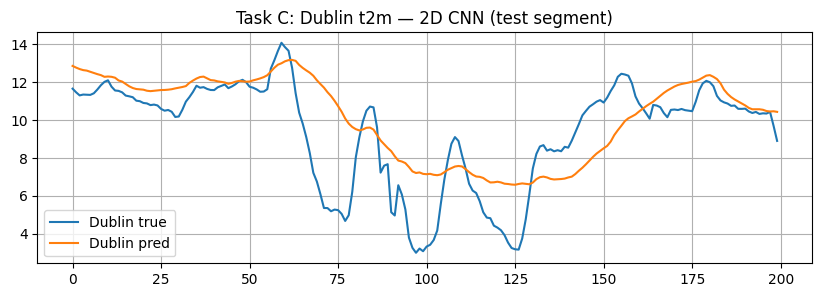

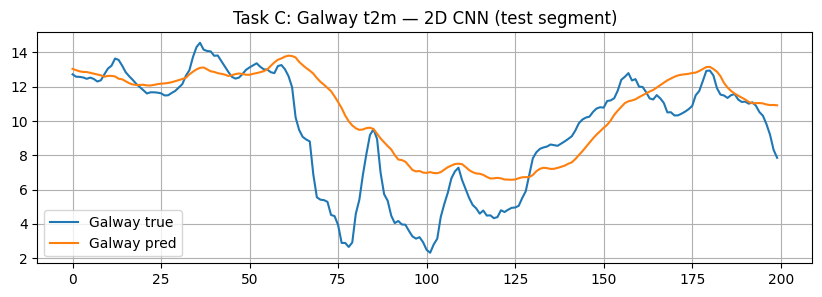

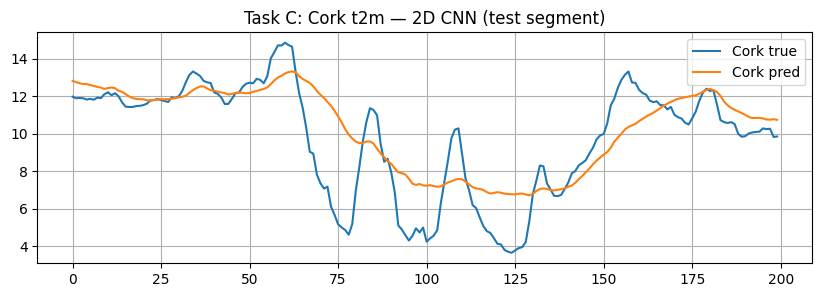

In [9]:

# Visual check for a short segment
nplot = 200
plt.figure(figsize=(10,3))
plt.plot(truth[:nplot,0], label='Dublin true'); plt.plot(pred[:nplot,0], label='Dublin pred')
plt.legend(); plt.title('Task C: Dublin t2m — 2D CNN (test segment)'); plt.grid(True); plt.show()

plt.figure(figsize=(10,3))
plt.plot(truth[:nplot,1], label='Galway true'); plt.plot(pred[:nplot,1], label='Galway pred')
plt.legend(); plt.title('Task C: Galway t2m — 2D CNN (test segment)'); plt.grid(True); plt.show()

plt.figure(figsize=(10,3))
plt.plot(truth[:nplot,2], label='Cork true'); plt.plot(pred[:nplot,2], label='Cork pred')
plt.legend(); plt.title('Task C: Cork t2m — 2D CNN (test segment)'); plt.grid(True); plt.show()



## 6) Notes & Next steps

- Try increasing the sequence length `T`, channels, or adding engineered features (sin/cos hour‑of‑day, day‑of‑year).  
- Try changing the forecast horizons to e.g. predict **24‑hour trajectories**.  
